<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing Kaggle

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

# Downloading data

In [4]:
!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023

 86% 123M/143M [00:01<00:00, 123MB/s]
100% 143M/143M [00:01<00:00, 127MB/s]


In [5]:
from zipfile import ZipFile

zip_file = ZipFile("/content/credit-card-fraud-detection-dataset-2023.zip")
zip_file.extractall()
zip_file.close()

# Obtaining Data

In [6]:
import pandas as pd

data = pd.read_csv("/content/creditcard_2023.csv")
data.head(2)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.12628,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.19009,0.296503,-0.248052,-0.064512,6531.37,0


# Exploring the Data

In [7]:
data.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
data.duplicated().sum()

0

#Defining Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("pca", PCA(n_components=2, svd_solver="randomized")),
    ("scaler", StandardScaler())
])

# Splitting into train and Test split

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.3)

# Training Models

In [11]:
x_train = train.drop("Class", axis=1)
y_train = train["Class"]

In [12]:
x_train_prepared = pipeline.fit_transform(x_train)

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)

log_reg.fit(x_train_prepared, y_train)

LogisticRegression(random_state=42)

In [14]:
from sklearn.model_selection import cross_val_score

log_reg_scores = cross_val_score(log_reg, x_train_prepared, y_train, cv=5, scoring="accuracy")

In [15]:
log_reg_scores

array([0.99830421, 0.99824138, 0.99795247, 0.99814089, 0.99829163])

## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

d_tree = DecisionTreeClassifier()
d_tree.fit(x_train_prepared, y_train)

DecisionTreeClassifier()

In [17]:
d_tree_scores = cross_val_score(d_tree, x_train_prepared, y_train, cv=5, scoring="accuracy")

In [18]:
d_tree_scores

array([0.99837958, 0.99835444, 0.9982037 , 0.99829163, 0.99829163])

## Random Forrest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rand_frst = RandomForestClassifier(random_state=42)
rand_frst.fit(x_train_prepared, y_train)

RandomForestClassifier(random_state=42)

In [20]:
rand_frst_score = cross_val_score(rand_frst, x_train_prepared, y_train, cv=5, scoring="accuracy")

In [21]:
rand_frst_score

array([0.9991207 , 0.99914581, 0.99903276, 0.99907045, 0.99913325])

## Voting Classifier

In [22]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[("log_reg", log_reg), ("d_tree", d_tree), ("rand_frst", rand_frst)],
                              voting="hard")

In [23]:
voting_clf.fit(x_train_prepared, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(random_state=42)),
                             ('d_tree', DecisionTreeClassifier()),
                             ('rand_frst',
                              RandomForestClassifier(random_state=42))])

In [24]:
voting_clf_scores = cross_val_score(voting_clf, x_train_prepared, y_train, cv=5, scoring="accuracy")

In [25]:
voting_clf_scores

array([0.99913326, 0.99914581, 0.99903276, 0.99907045, 0.99913325])

# Evaluating the Models

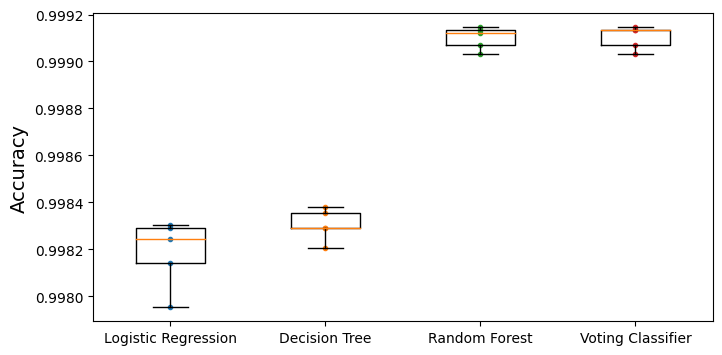

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*5, log_reg_scores, ".")
plt.plot([2]*5, d_tree_scores, ".")
plt.plot([3]*5, rand_frst_score, ".")
plt.plot([4]*5, voting_clf_scores, ".")
plt.boxplot([log_reg_scores, d_tree_scores, rand_frst_score, voting_clf_scores], labels=("Logistic Regression","Decision Tree","Random Forest", "Voting Classifier"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()
# plt.savefig(fname="box_plot.jpg")


# Testing model

In [27]:
x_test = test.drop("Class", axis=1)
y_test = test["Class"]

In [28]:
x_test_prepared = pipeline.transform(x_test)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

preds = voting_clf.predict(x_test_prepared)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

1.0


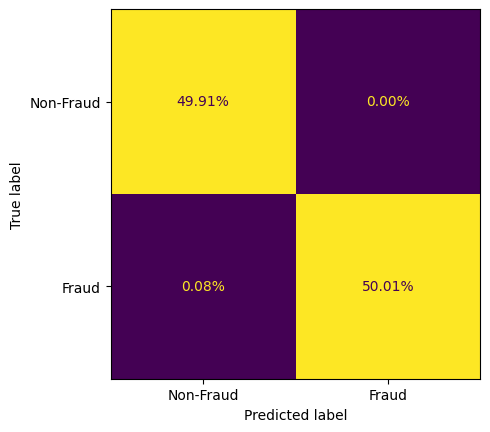

In [33]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        normalize='all'
    ),
    display_labels=['Non-Fraud', 'Fraud'],
)

# Plot the confusion matrix with specified formatting
cm.plot(
    values_format='.2%',  # Display values as percentages with two decimal places
    colorbar=False,  # Do not display the color bar
)

# Display the confusion matrix plot
plt.show()